# Demo usecase of the expert-knowledge Classifier

In [1]:
import argparse
import os
import torch
import optuna
import joblib
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

os.chdir("..")

from DermaClassifier.inference.test_setup import test_metrices
import DermaClassifier.utils.config as config
import DermaClassifier.utils.train_setup as train_setup
from DermaClassifier.utils.utils import get_saving_path, fix_randomness, get_device, set_hyperparameter_demo
import DermaClassifier.utils.hyperparmeter as hp
from DermaClassifier.inference.test_setup import test_setup
from torcheval.metrics import MulticlassAccuracy, MulticlassAUROC, MulticlassConfusionMatrix, MulticlassF1Score

## Demo case with minimal example

In this Jupyter Notebook, we demonstrate how to use our expert-knowledge classifier and generate reproducible results on a small example dataset. The images used are from the HAM10K dataset. The accompanying table, `demo_label_data.csv`, contains the following information:

**slideId**: Identifier for the slide \
**imageIds**: Identifiers for the individual images given in the directory `data` \
**diagnosis**: The ground truth diagnosis for each image \
**softlabel1** to **softlabel8**: Randomly selected diagnoses from us, provided as an example to illustrate how our soft-label approach functions

### Training

Set parameters to train the model.

In [2]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')
args.save_path = "./runs/demo"
args.model = "efficientnetB2"
args.epochs = 10
args.loss = "ce"
args.seed = 42
args.demo = True
args.images_path = os.path.join("demo", "data")
config.mask = None
config.preprocess = "rgb_darker"

#### Optimization

Example of how to optimize. The parameters are stored in an optuna database in order to obtain as much information as possible on the optimum hyperparameters. In addition, the hyperparameters are stored in tables.

##### Majority Vote

Set the `config.encode_label` variable to "ohe", that the optimization process is done for approach with one-hot-encoding for the label decoding.

Values of the last epoch of the last trial run:
```
EPOCH 10/10: TRAIN loss > 0.873 	 accuracy > 0.644 	 AUROC > 0.544 | VAL loss > 0.877 	 accuracy > 0.617 	 AUROC > 0.616
```

Best optimal trial:
```
Best is trial 1 with value: 0.6962499618530273.
```

In [3]:
config.encode_label = "ohe" 
args = set_hyperparameter_demo(args, config.preprocess, config.encode_label)

# set the hyperparameter 
args.optimize = True
args.trials = 3

sampler = optuna.samplers.RandomSampler(seed=42)
optuna.seed = 42
fix_randomness(args.seed)

pruner = optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", storage=config.local_path,
                            study_name=f"demo_{config.preprocess}_{config.encode_label}",
                            load_if_exists=True, sampler=sampler, pruner=pruner)

study.optimize(lambda trial: train_setup.objective(trial, args), n_trials=args.trials, timeout=None)

joblib.dump(study, os.path.join(get_saving_path(args), "study" +".pkl"))
study.trials_dataframe().to_csv(os.path.join(get_saving_path(args), "trials" +".csv"))

[I 2025-04-22 13:36:02,956] A new study created in RDB with name: demo_rgb_darker_ohe


PARAMETER: 3 | 0.0004370861069626262 | 9.507143064099161e-05 | efficientnetB2 | 0.839196365086843
Device defined as cuda:0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14019.96it/s]


EPOCH 1/10: TRAIN loss > 1.077 	 accuracy > 0.389 	 AUROC > 0.389 | VAL loss > 1.004 	 accuracy > 0.833 	 AUROC > 0.833
EPOCH 2/10: TRAIN loss > 0.981 	 accuracy > 0.528 	 AUROC > 0.477 | VAL loss > 0.975 	 accuracy > 0.833 	 AUROC > 0.792
EarlyStopping Counter: 1 out of 15
EPOCH 3/10: TRAIN loss > 0.846 	 accuracy > 0.648 	 AUROC > 0.63 | VAL loss > 0.881 	 accuracy > 0.778 	 AUROC > 0.787
EPOCH 4/10: TRAIN loss > 0.843 	 accuracy > 0.667 	 AUROC > 0.646 | VAL loss > 0.785 	 accuracy > 0.792 	 AUROC > 0.779
EPOCH 5/10: TRAIN loss > 0.706 	 accuracy > 0.722 	 AUROC > 0.705 | VAL loss > 0.815 	 accuracy > 0.767 	 AUROC > 0.743
EPOCH 6/10: TRAIN loss > 0.788 	 accuracy > 0.731 	 AUROC > 0.71 | VAL loss > 0.847 	 accuracy > 0.778 	 AUROC > 0.726
EPOCH 7/10: TRAIN loss > 0.829 	 accuracy > 0.738 	 AUROC > 0.701 | VAL loss > 0.826 	 accuracy > 0.786 	 AUROC > 0.712
EarlyStopping Counter: 1 out of 15
EPOCH 8/10: TRAIN loss > 0.65 	 accuracy > 0.771 	 AUROC > 0.726 | VAL loss > 0.769 	 accura

[I 2025-04-22 13:36:14,435] Trial 0 finished with value: 0.6700000166893005 and parameters: {'lr': 0.0004370861069626262, 'wd': 9.507143064099161e-05, 'sampling': 0.839196365086843, 'batch_size': 3, 'weight_melanom': 1, 'weight_insitu': 1}. Best is trial 0 with value: 0.6700000166893005.


PARAMETER: 4 | 0.00015227525095137952 | 8.661761457749353e-05 | efficientnetB2 | 0.7606690070459252
Device defined as cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 7548.24it/s]


EPOCH 1/10: TRAIN loss > 1.1 	 accuracy > 0.556 	 AUROC > 0.444 | VAL loss > 1.055 	 accuracy > 0.5 	 AUROC > 0.75
EPOCH 2/10: TRAIN loss > 1.034 	 accuracy > 0.667 	 AUROC > 0.569 | VAL loss > 1.047 	 accuracy > 0.583 	 AUROC > 0.708
EPOCH 3/10: TRAIN loss > 0.993 	 accuracy > 0.722 	 AUROC > 0.659 | VAL loss > 1.042 	 accuracy > 0.611 	 AUROC > 0.676
EPOCH 4/10: TRAIN loss > 0.973 	 accuracy > 0.722 	 AUROC > 0.66 | VAL loss > 1.035 	 accuracy > 0.542 	 AUROC > 0.63
EPOCH 5/10: TRAIN loss > 0.954 	 accuracy > 0.744 	 AUROC > 0.675 | VAL loss > 1.018 	 accuracy > 0.533 	 AUROC > 0.617
EarlyStopping Counter: 1 out of 15
EPOCH 6/10: TRAIN loss > 0.853 	 accuracy > 0.787 	 AUROC > 0.713 | VAL loss > 1.0 	 accuracy > 0.556 	 AUROC > 0.634
EPOCH 7/10: TRAIN loss > 0.834 	 accuracy > 0.794 	 AUROC > 0.723 | VAL loss > 0.99 	 accuracy > 0.571 	 AUROC > 0.644
EPOCH 8/10: TRAIN loss > 0.8 	 accuracy > 0.806 	 AUROC > 0.735 | VAL loss > 0.957 	 accuracy > 0.604 	 AUROC > 0.66
EPOCH 9/10: TRAIN 

[I 2025-04-22 13:36:24,265] Trial 1 finished with value: 0.6962499618530273 and parameters: {'lr': 0.00015227525095137952, 'wd': 8.661761457749353e-05, 'sampling': 0.7606690070459252, 'batch_size': 4, 'weight_melanom': 1, 'weight_insitu': 5}. Best is trial 1 with value: 0.6962499618530273.


EPOCH 10/10: TRAIN loss > 0.747 	 accuracy > 0.828 	 AUROC > 0.756 | VAL loss > 0.89 	 accuracy > 0.667 	 AUROC > 0.696
PARAMETER: 1 | 0.0008491983767203796 | 2.1233911067827617e-05 | efficientnetB2 | 0.5090949803242604
Device defined as cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 6247.72it/s]


EPOCH 1/10: TRAIN loss > 1.007 	 accuracy > 0.444 	 AUROC > 0.398 | VAL loss > 0.878 	 accuracy > 0.667 	 AUROC > 0.75
EPOCH 2/10: TRAIN loss > 0.888 	 accuracy > 0.556 	 AUROC > 0.422 | VAL loss > 0.813 	 accuracy > 0.667 	 AUROC > 0.75
EarlyStopping Counter: 1 out of 15
EPOCH 3/10: TRAIN loss > 0.884 	 accuracy > 0.593 	 AUROC > 0.481 | VAL loss > 0.859 	 accuracy > 0.667 	 AUROC > 0.699
EarlyStopping Counter: 2 out of 15
EPOCH 4/10: TRAIN loss > 0.882 	 accuracy > 0.611 	 AUROC > 0.515 | VAL loss > 0.873 	 accuracy > 0.667 	 AUROC > 0.682
EarlyStopping Counter: 3 out of 15
EPOCH 5/10: TRAIN loss > 0.882 	 accuracy > 0.622 	 AUROC > 0.537 | VAL loss > 0.966 	 accuracy > 0.667 	 AUROC > 0.64
EarlyStopping Counter: 4 out of 15
EPOCH 6/10: TRAIN loss > 0.879 	 accuracy > 0.63 	 AUROC > 0.551 | VAL loss > 0.877 	 accuracy > 0.667 	 AUROC > 0.627
EarlyStopping Counter: 5 out of 15
EPOCH 7/10: TRAIN loss > 0.886 	 accuracy > 0.635 	 AUROC > 0.54 | VAL loss > 1.112 	 accuracy > 0.595 	 AURO

[I 2025-04-22 13:36:39,114] Trial 2 finished with value: 0.6158333420753479 and parameters: {'lr': 0.0008491983767203796, 'wd': 2.1233911067827617e-05, 'sampling': 0.5090949803242604, 'batch_size': 1, 'weight_melanom': 1, 'weight_insitu': 3}. Best is trial 1 with value: 0.6962499618530273.


EPOCH 10/10: TRAIN loss > 0.873 	 accuracy > 0.644 	 AUROC > 0.544 | VAL loss > 0.877 	 accuracy > 0.617 	 AUROC > 0.616


##### Soft-labels

Set the `config.encode_label` variable to "sl", that the optimization process is done for approach with soft label for the label decoding.

Values of the last epoch of the last trial run:
```
EPOCH 10/10: TRAIN loss > 1.104 	 accuracy > 0.656 	 AUROC > 0.56 | VAL loss > 1.357 	 accuracy > 0.4 	 AUROC > 0.442
```

Best optimal trial:
```
Best is trial 0 with value: 0.6416666507720947.
```

In [4]:
config.encode_label = "sl" 
args = set_hyperparameter_demo(args, config.preprocess, config.encode_label)

args.optimize = True
args.trials = 3

sampler = optuna.samplers.RandomSampler(seed=42)
optuna.seed = 42
fix_randomness(args.seed)

pruner = optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", storage=config.local_path,
                            study_name=f"demo_{config.preprocess}_{config.encode_label}",
                            load_if_exists=True, sampler=sampler, pruner=pruner)

study.optimize(lambda trial: train_setup.objective(trial, args), n_trials=args.trials, timeout=None)

joblib.dump(study, os.path.join(get_saving_path(args), "study" +".pkl"))
study.trials_dataframe().to_csv(os.path.join(get_saving_path(args), "trials" +".csv"))

[I 2025-04-22 13:37:11,857] A new study created in RDB with name: demo_rgb_darker_sl


PARAMETER: 3 | 0.0004370861069626262 | 9.507143064099161e-05 | efficientnetB2 | 0.839196365086843
Device defined as cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2772.18it/s]


EPOCH 1/10: TRAIN loss > 1.08 	 accuracy > 0.389 	 AUROC > 0.407 | VAL loss > 1.036 	 accuracy > 0.833 	 AUROC > 0.75
EPOCH 2/10: TRAIN loss > 1.003 	 accuracy > 0.528 	 AUROC > 0.49 | VAL loss > 1.016 	 accuracy > 0.75 	 AUROC > 0.698
EPOCH 3/10: TRAIN loss > 0.896 	 accuracy > 0.63 	 AUROC > 0.624 | VAL loss > 0.955 	 accuracy > 0.722 	 AUROC > 0.639
EPOCH 4/10: TRAIN loss > 0.912 	 accuracy > 0.653 	 AUROC > 0.644 | VAL loss > 0.909 	 accuracy > 0.708 	 AUROC > 0.661
EPOCH 5/10: TRAIN loss > 0.812 	 accuracy > 0.711 	 AUROC > 0.7 | VAL loss > 0.921 	 accuracy > 0.7 	 AUROC > 0.663
EarlyStopping Counter: 1 out of 15
EPOCH 6/10: TRAIN loss > 0.876 	 accuracy > 0.722 	 AUROC > 0.693 | VAL loss > 0.92 	 accuracy > 0.722 	 AUROC > 0.667
EPOCH 7/10: TRAIN loss > 0.931 	 accuracy > 0.698 	 AUROC > 0.676 | VAL loss > 0.892 	 accuracy > 0.738 	 AUROC > 0.67
EPOCH 8/10: TRAIN loss > 0.751 	 accuracy > 0.729 	 AUROC > 0.704 | VAL loss > 0.873 	 accuracy > 0.75 	 AUROC > 0.677
EPOCH 9/10: TRAIN

[I 2025-04-22 13:37:21,230] Trial 0 finished with value: 0.6416666507720947 and parameters: {'lr': 0.0004370861069626262, 'wd': 9.507143064099161e-05, 'sampling': 0.839196365086843, 'batch_size': 3, 'weight_melanom': 1, 'weight_insitu': 1}. Best is trial 0 with value: 0.6416666507720947.


EPOCH 10/10: TRAIN loss > 0.823 	 accuracy > 0.756 	 AUROC > 0.72 | VAL loss > 1.015 	 accuracy > 0.717 	 AUROC > 0.642
PARAMETER: 4 | 0.00015227525095137952 | 8.661761457749353e-05 | efficientnetB2 | 0.7606690070459252
Device defined as cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 2545.86it/s]


EPOCH 1/10: TRAIN loss > 1.454 	 accuracy > 0.389 	 AUROC > 0.435 | VAL loss > 1.442 	 accuracy > 0.5 	 AUROC > 0.708
EPOCH 2/10: TRAIN loss > 1.401 	 accuracy > 0.528 	 AUROC > 0.589 | VAL loss > 1.441 	 accuracy > 0.5 	 AUROC > 0.688
EarlyStopping Counter: 1 out of 15
EPOCH 3/10: TRAIN loss > 1.382 	 accuracy > 0.574 	 AUROC > 0.673 | VAL loss > 1.441 	 accuracy > 0.556 	 AUROC > 0.648
EPOCH 4/10: TRAIN loss > 1.38 	 accuracy > 0.611 	 AUROC > 0.671 | VAL loss > 1.444 	 accuracy > 0.542 	 AUROC > 0.607
EPOCH 5/10: TRAIN loss > 1.407 	 accuracy > 0.644 	 AUROC > 0.685 | VAL loss > 1.44 	 accuracy > 0.567 	 AUROC > 0.587
EPOCH 6/10: TRAIN loss > 1.329 	 accuracy > 0.685 	 AUROC > 0.711 | VAL loss > 1.436 	 accuracy > 0.583 	 AUROC > 0.59
EPOCH 7/10: TRAIN loss > 1.331 	 accuracy > 0.706 	 AUROC > 0.726 | VAL loss > 1.436 	 accuracy > 0.595 	 AUROC > 0.585
EPOCH 8/10: TRAIN loss > 1.315 	 accuracy > 0.722 	 AUROC > 0.739 | VAL loss > 1.432 	 accuracy > 0.604 	 AUROC > 0.587
EarlyStoppin

[I 2025-04-22 13:37:30,734] Trial 1 finished with value: 0.5891667008399963 and parameters: {'lr': 0.00015227525095137952, 'wd': 8.661761457749353e-05, 'sampling': 0.7606690070459252, 'batch_size': 4, 'weight_melanom': 1, 'weight_insitu': 5}. Best is trial 0 with value: 0.6416666507720947.


EPOCH 10/10: TRAIN loss > 1.248 	 accuracy > 0.756 	 AUROC > 0.761 | VAL loss > 1.425 	 accuracy > 0.633 	 AUROC > 0.589
PARAMETER: 1 | 0.0008491983767203796 | 2.1233911067827617e-05 | efficientnetB2 | 0.5090949803242604
Device defined as cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 4180.37it/s]


EPOCH 1/10: TRAIN loss > 1.232 	 accuracy > 0.444 	 AUROC > 0.375 | VAL loss > 1.232 	 accuracy > 0.667 	 AUROC > 0.5
EPOCH 2/10: TRAIN loss > 1.187 	 accuracy > 0.556 	 AUROC > 0.403 | VAL loss > 1.266 	 accuracy > 0.667 	 AUROC > 0.333
EarlyStopping Counter: 1 out of 15
EPOCH 3/10: TRAIN loss > 1.168 	 accuracy > 0.593 	 AUROC > 0.465 | VAL loss > 1.252 	 accuracy > 0.611 	 AUROC > 0.356
EPOCH 4/10: TRAIN loss > 1.17 	 accuracy > 0.611 	 AUROC > 0.49 | VAL loss > 1.273 	 accuracy > 0.583 	 AUROC > 0.372
EPOCH 5/10: TRAIN loss > 1.173 	 accuracy > 0.622 	 AUROC > 0.493 | VAL loss > 1.29 	 accuracy > 0.533 	 AUROC > 0.383
EPOCH 6/10: TRAIN loss > 1.17 	 accuracy > 0.63 	 AUROC > 0.494 | VAL loss > 1.213 	 accuracy > 0.556 	 AUROC > 0.422
EPOCH 7/10: TRAIN loss > 1.152 	 accuracy > 0.635 	 AUROC > 0.503 | VAL loss > 1.298 	 accuracy > 0.524 	 AUROC > 0.428
EPOCH 8/10: TRAIN loss > 1.157 	 accuracy > 0.639 	 AUROC > 0.519 | VAL loss > 1.337 	 accuracy > 0.479 	 AUROC > 0.431
EPOCH 9/10: 

[I 2025-04-22 13:37:44,104] Trial 2 finished with value: 0.44166669249534607 and parameters: {'lr': 0.0008491983767203796, 'wd': 2.1233911067827617e-05, 'sampling': 0.5090949803242604, 'batch_size': 1, 'weight_melanom': 1, 'weight_insitu': 3}. Best is trial 0 with value: 0.6416666507720947.


EPOCH 10/10: TRAIN loss > 1.104 	 accuracy > 0.656 	 AUROC > 0.56 | VAL loss > 1.357 	 accuracy > 0.4 	 AUROC > 0.442


#### Train model with our hyperparameter

Load the optimized hyperparameter for the expert-knowledge classifier and train the small example.

##### Majority vote

Set the `config.encode_label` variable to "ohe", that the training process is done for approach with one-hot-encoding for the label decoding.

Values of the last epochs of the small training:
```
EPOCH 8/10: TRAIN loss > 0.996 	 accuracy > 0.785 	 AUROC > 0.752 | VAL loss > 1.348 	 accuracy > 0.562 	 AUROC > 0.624
EPOCH 9/10: TRAIN loss > 0.972 	 accuracy > 0.796 	 AUROC > 0.765 | VAL loss > 1.348 	 accuracy > 0.537 	 AUROC > 0.609
EPOCH 10/10: TRAIN loss > 1.112 	 accuracy > 0.789 	 AUROC > 0.753 | VAL loss > 1.365 	 accuracy > 0.517 	 AUROC > 0.587
```

In [5]:
config.encode_label = "ohe" 
args = set_hyperparameter_demo(args, config.preprocess, config.encode_label)
args.batch_size = 5

train_setup.train(args, weight_loss=hp.weight_loss(config.preprocess, config.encode))

Device defined as cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 7832.50it/s]


EPOCH 1/10: TRAIN loss > 1.52 	 accuracy > 0.444 	 AUROC > 0.435 | VAL loss > 1.41 	 accuracy > 0.667 	 AUROC > 0.75
EPOCH 2/10: TRAIN loss > 1.378 	 accuracy > 0.528 	 AUROC > 0.519 | VAL loss > 1.398 	 accuracy > 0.667 	 AUROC > 0.719
EarlyStopping Counter: 1 out of 15
EPOCH 3/10: TRAIN loss > 1.348 	 accuracy > 0.593 	 AUROC > 0.602 | VAL loss > 1.387 	 accuracy > 0.667 	 AUROC > 0.708
EarlyStopping Counter: 2 out of 15
EPOCH 4/10: TRAIN loss > 1.334 	 accuracy > 0.639 	 AUROC > 0.635 | VAL loss > 1.371 	 accuracy > 0.667 	 AUROC > 0.701
EarlyStopping Counter: 3 out of 15
EPOCH 5/10: TRAIN loss > 1.277 	 accuracy > 0.7 	 AUROC > 0.679 | VAL loss > 1.37 	 accuracy > 0.633 	 AUROC > 0.673
EPOCH 6/10: TRAIN loss > 1.262 	 accuracy > 0.722 	 AUROC > 0.703 | VAL loss > 1.36 	 accuracy > 0.611 	 AUROC > 0.655
EPOCH 7/10: TRAIN loss > 1.078 	 accuracy > 0.762 	 AUROC > 0.732 | VAL loss > 1.358 	 accuracy > 0.595 	 AUROC > 0.639
EPOCH 8/10: TRAIN loss > 0.996 	 accuracy > 0.785 	 AUROC > 0.

##### Softlabel

Set the `config.encode_label` variable to "sl", that the training process is done for approach with soft labels for the label decoding.

Values of the last epochs of the small training:
```
EPOCH 8/10: TRAIN loss > 1.244 	 accuracy > 0.743 	 AUROC > 0.705 | VAL loss > 1.412 	 accuracy > 0.479 	 AUROC > 0.505
EarlyStopping Counter: 1 out of 15
EPOCH 9/10: TRAIN loss > 1.242 	 accuracy > 0.741 	 AUROC > 0.71 | VAL loss > 1.41 	 accuracy > 0.481 	 AUROC > 0.493
EarlyStopping Counter: 2 out of 15
EPOCH 10/10: TRAIN loss > 1.228 	 accuracy > 0.744 	 AUROC > 0.72 | VAL loss > 1.41 	 accuracy > 0.483 	 AUROC > 0.482
EarlyStopping Counter: 3 out of 15
```

In [6]:
config.encode_label = "sl" 
args = set_hyperparameter_demo(args, config.preprocess, config.encode_label)
args.batch_size = 4

train_setup.train(args, weight_loss=hp.weight_loss(config.preprocess, config.encode))

Device defined as cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 4451.76it/s]


EPOCH 1/10: TRAIN loss > 1.489 	 accuracy > 0.444 	 AUROC > 0.477 | VAL loss > 1.431 	 accuracy > 0.5 	 AUROC > 0.708
EPOCH 2/10: TRAIN loss > 1.366 	 accuracy > 0.611 	 AUROC > 0.598 | VAL loss > 1.43 	 accuracy > 0.583 	 AUROC > 0.667
EPOCH 3/10: TRAIN loss > 1.398 	 accuracy > 0.722 	 AUROC > 0.656 | VAL loss > 1.425 	 accuracy > 0.556 	 AUROC > 0.639
EPOCH 4/10: TRAIN loss > 1.389 	 accuracy > 0.694 	 AUROC > 0.65 | VAL loss > 1.423 	 accuracy > 0.542 	 AUROC > 0.591
EPOCH 5/10: TRAIN loss > 1.417 	 accuracy > 0.7 	 AUROC > 0.659 | VAL loss > 1.422 	 accuracy > 0.533 	 AUROC > 0.555
EarlyStopping Counter: 1 out of 15
EPOCH 6/10: TRAIN loss > 1.32 	 accuracy > 0.731 	 AUROC > 0.681 | VAL loss > 1.412 	 accuracy > 0.5 	 AUROC > 0.529
EPOCH 7/10: TRAIN loss > 1.259 	 accuracy > 0.738 	 AUROC > 0.69 | VAL loss > 1.412 	 accuracy > 0.476 	 AUROC > 0.514
EPOCH 8/10: TRAIN loss > 1.244 	 accuracy > 0.743 	 AUROC > 0.705 | VAL loss > 1.412 	 accuracy > 0.479 	 AUROC > 0.505
EarlyStopping C

### Prediction

In [7]:
parser = argparse.ArgumentParser()
args = parser.parse_args('')

args.data_path = "./demo/"
args.demo = True
args.images_path = os.path.join("demo", "data")
config.mask = None

#### Majority vote

Get the predictions for the demonstration dataset with our pre-trained model for the majority vote (one-hot encoding).
```
Demo accuracy:  0.3333
Demo f1:  0.1905
Demo bal_accuracy:  nan
Demo auroc:  [0.5    0.5    0.625  0.5417]
Demo confmatrix:  [[0.0, 1.0, 1.0], [0.0, 0.0, 0.0], [1.0, 1.0, 2.0]]
```

In [8]:
config.encode_label = "ohe" 
args.model = "./weights" + "/" + config.encode_label + "/" + config.preprocess

results = test_setup(args)

Device defined as cuda:0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11239.76it/s]


Demo set


6it [00:00,  9.82it/s]


Demo accuracy:  0.3333
Demo f1:  0.1905
Demo bal_accuracy:  nan
Demo auroc:  [0.5    0.5    0.625  0.5417]
Demo confmatrix:  [[0.0, 1.0, 1.0], [0.0, 0.0, 0.0], [1.0, 1.0, 2.0]]


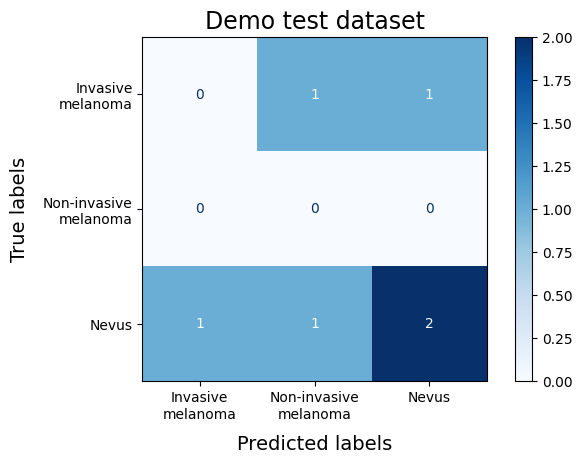

In [9]:
cm = results["confmatrix"]
_, ax_conf_matrix = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(np.array(cm), display_labels=['Invasive\nmelanoma', 'Non-invasive\nmelanoma', 'Nevus'])
disp.plot(ax=ax_conf_matrix, cmap=plt.cm.Blues, values_format='.3g')
ax_conf_matrix.set_xlabel('Predicted labels', fontsize=14, labelpad=10)  # X-Achsen-Beschriftung mit Schriftgröße 14
ax_conf_matrix.set_ylabel('True labels', fontsize=14, labelpad=10)       # Y-Achsen-Beschriftung mit Schriftgröße 14
ax_conf_matrix.set_title('Demo test dataset', fontsize=17) 
plt.tight_layout(pad=2.0)

#### Softlabel

Get the predictions for the demonstration dataset with our pre-trained model for the uncertainty label (soft label).
```
Demo accuracy:  0.8333
Demo f1:  0.7778
Demo bal_accuracy:  nan
Demo auroc:  [1.   0.5  0.75 0.75]
Demo confmatrix:  [[1.0, 0.0, 1.0], [0.0, 0.0, 0.0], [0.0, 0.0, 4.0]]
```

In [10]:
config.encode_label = "sl" 
args.model = "./weights" + "/" + config.encode_label + "/" + config.preprocess

results = test_setup(args)

Device defined as cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5281.39it/s]


Demo set


6it [00:00, 10.68it/s]


Demo accuracy:  0.8333
Demo f1:  0.7778
Demo bal_accuracy:  nan
Demo auroc:  [1.   0.5  0.75 0.75]
Demo confmatrix:  [[1.0, 0.0, 1.0], [0.0, 0.0, 0.0], [0.0, 0.0, 4.0]]


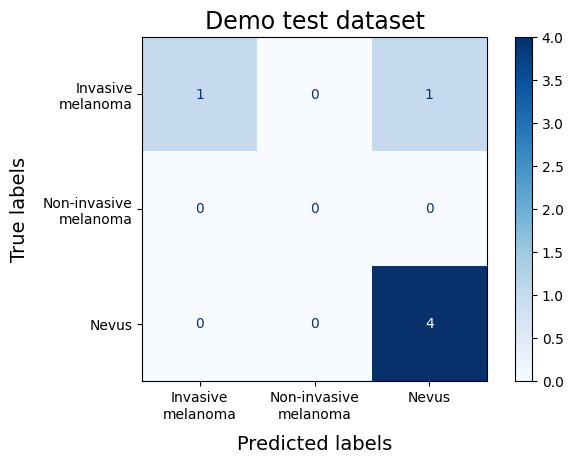

In [11]:
cm = results["confmatrix"]
_, ax_conf_matrix = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(np.array(cm), display_labels=['Invasive\nmelanoma', 'Non-invasive\nmelanoma', 'Nevus'])
disp.plot(ax=ax_conf_matrix, cmap=plt.cm.Blues, values_format='.3g')
ax_conf_matrix.set_xlabel('Predicted labels', fontsize=14, labelpad=10)  # X-Achsen-Beschriftung mit Schriftgröße 14
ax_conf_matrix.set_ylabel('True labels', fontsize=14, labelpad=10)       # Y-Achsen-Beschriftung mit Schriftgröße 14
ax_conf_matrix.set_title('Demo test dataset', fontsize=17) 
plt.tight_layout(pad=2.0)

## Results with predictions

Compute the evaluation metrics for all predictions on the test holdout set, external test set, and validation set using all of our models, including those with different preprocessing methods and label encoding strategies for the diagnoses.

In [12]:
pred_hold = pd.read_csv(Path("predictions", "all_predictions", "predictions_holdout.csv"))
pred_exte = pd.read_csv(Path("predictions", "all_predictions", "predictions_extern.csv"))
pred_vali = pd.read_csv(Path("predictions", "all_predictions", "predictions_val.csv"))

pred = lambda preprocess, encode: "{}_{}".format({"normal": "normal", "rgb_darker": "darker", 
                                                  "rgb_contrast": "contrast", "rgb_gray": "gray"}[preprocess],
                                                 {"ohe": "majority", "sl": "softlabel"}[encode])

diagnosis = {"invasive melanoma": "melanoma", "non-invasive melanoma": "in-situ tumor","nevus": "nevus"}

pred_hold.pathoPanel = pred_hold.pathoPanel.apply(lambda row: diagnosis[row])
pred_exte.pathoPanel = pred_exte.pathoPanel.apply(lambda row: diagnosis[row])
pred_vali.pathoPanel = pred_vali.pathoPanel.apply(lambda row: diagnosis[row])

### Majority Vote

In [13]:
config.encode_label = "ohe"

#### Darker lesion

Metrics for the predictions made by the model using the darker lesion preprocessing and majority vote encoding of the diagnoses.
```
{'accuracy': tensor(0.8333),
 'confmatrix': tensor([[21.,  1.,  4.],
         [ 2.,  7.,  1.],
         [ 5.,  2., 47.]]),
 'f1': tensor(0.7882),
 'auroc': tensor([0.9267, 0.9062, 0.9347]),
 'auroc_avg': tensor(0.9225)}
```

In [14]:
config.preprocess = "rgb_darker"

test_metrices(pred_hold, pred(config.preprocess, config.encode_label))

{'accuracy': tensor(0.8333),
 'confmatrix': tensor([[21.,  1.,  4.],
         [ 2.,  7.,  1.],
         [ 5.,  2., 47.]]),
 'f1': tensor(0.7882),
 'auroc': tensor([0.9267, 0.9062, 0.9347]),
 'auroc_avg': tensor(0.9225)}

#### Normal input

Metrics for the predictions made by the model using the normal image without preprocessing and majority vote encoding of the diagnoses.
```
{'accuracy': tensor(0.8000),
 'confmatrix': tensor([[20.,  2.,  4.],
         [ 4.,  6.,  0.],
         [ 5.,  3., 46.]]),
 'f1': tensor(0.7278),
 'auroc': tensor([0.9044, 0.9237, 0.9131]),
 'auroc_avg': tensor(0.9138)}
```

In [15]:
config.preprocess = "normal"

test_metrices(pred_hold, pred(config.preprocess, config.encode_label))

{'accuracy': tensor(0.8000),
 'confmatrix': tensor([[20.,  2.,  4.],
         [ 4.,  6.,  0.],
         [ 5.,  3., 46.]]),
 'f1': tensor(0.7278),
 'auroc': tensor([0.9044, 0.9237, 0.9131]),
 'auroc_avg': tensor(0.9138)}

#### Contrast lesion

Metrics for the predictions made by the model using the higher contrast lesion preprocessing and majority vote encoding of the diagnoses.
```
{'accuracy': tensor(0.7889),
 'confmatrix': tensor([[20.,  3.,  3.],
         [ 2.,  7.,  1.],
         [ 6.,  4., 44.]]),
 'f1': tensor(0.7289),
 'auroc': tensor([0.9249, 0.8913, 0.9311]),
 'auroc_avg': tensor(0.9157)}
```

In [16]:
config.preprocess = "rgb_contrast"

test_metrices(pred_hold, pred(config.preprocess, config.encode_label))

{'accuracy': tensor(0.7889),
 'confmatrix': tensor([[20.,  3.,  3.],
         [ 2.,  7.,  1.],
         [ 6.,  4., 44.]]),
 'f1': tensor(0.7289),
 'auroc': tensor([0.9249, 0.8913, 0.9311]),
 'auroc_avg': tensor(0.9157)}

#### Gray image

Metrics for the predictions made by the model using the darker lesion for the gray image preprocessing and majority vote encoding of the diagnoses.
```
{'accuracy': tensor(0.7667),
 'confmatrix': tensor([[17.,  4.,  5.],
         [ 2.,  7.,  1.],
         [ 4.,  5., 45.]]),
 'f1': tensor(0.6965),
 'auroc': tensor([0.9213, 0.8587, 0.9234]),
 'auroc_avg': tensor(0.9011)}
```

In [17]:
config.preprocess = "rgb_gray"

test_metrices(pred_hold, pred(config.preprocess, config.encode_label))

{'accuracy': tensor(0.7667),
 'confmatrix': tensor([[17.,  4.,  5.],
         [ 2.,  7.,  1.],
         [ 4.,  5., 45.]]),
 'f1': tensor(0.6965),
 'auroc': tensor([0.9213, 0.8587, 0.9234]),
 'auroc_avg': tensor(0.9011)}

### Soft labels

In [18]:
config.encode_label = "sl"

#### Darker lesion

Metrics for the predictions made by the model using the darker lesion preprocessing and soft label encoding of the diagnoses.
```
{'accuracy': tensor(0.8222),
 'confmatrix': tensor([[18.,  4.,  4.],
         [ 1.,  7.,  2.],
         [ 3.,  2., 49.]]),
 'f1': tensor(0.7526),
 'auroc': tensor([0.9141, 0.9013, 0.9239]),
 'auroc_avg': tensor(0.9131)}
```

In [19]:
config.preprocess = "rgb_darker"

test_metrices(pred_hold, pred(config.preprocess, config.encode_label))

{'accuracy': tensor(0.8222),
 'confmatrix': tensor([[18.,  4.,  4.],
         [ 1.,  7.,  2.],
         [ 3.,  2., 49.]]),
 'f1': tensor(0.7526),
 'auroc': tensor([0.9141, 0.9013, 0.9239]),
 'auroc_avg': tensor(0.9131)}

#### Normal input

Metrics for the predictions made by the model using the normal image without preprocessing and soft label encoding of the diagnoses.
```
{'accuracy': tensor(0.8111),
 'confmatrix': tensor([[18.,  4.,  4.],
         [ 0.,  9.,  1.],
         [ 5.,  3., 46.]]),
 'f1': tensor(0.7677),
 'auroc': tensor([0.9062, 0.9275, 0.9259]),
 'auroc_avg': tensor(0.9199)}
```

In [20]:
config.preprocess = "normal"

test_metrices(pred_hold, pred(config.preprocess, config.encode_label))

{'accuracy': tensor(0.8111),
 'confmatrix': tensor([[18.,  4.,  4.],
         [ 0.,  9.,  1.],
         [ 5.,  3., 46.]]),
 'f1': tensor(0.7677),
 'auroc': tensor([0.9062, 0.9275, 0.9259]),
 'auroc_avg': tensor(0.9199)}

#### Contrast lesion

Metrics for the predictions made by the model using the higher contrast lesion preprocessing and soft label encoding of the diagnoses.
```
{'accuracy': tensor(0.8333),
 'confmatrix': tensor([[18.,  5.,  3.],
         [ 0.,  9.,  1.],
         [ 3.,  3., 48.]]),
 'f1': tensor(0.7794),
 'auroc': tensor([0.9099, 0.9000, 0.9156]),
 'auroc_avg': tensor(0.9085)}
```

In [21]:
config.preprocess = "rgb_contrast"

test_metrices(pred_hold, pred(config.preprocess, config.encode_label))

{'accuracy': tensor(0.8333),
 'confmatrix': tensor([[18.,  5.,  3.],
         [ 0.,  9.,  1.],
         [ 3.,  3., 48.]]),
 'f1': tensor(0.7794),
 'auroc': tensor([0.9099, 0.9000, 0.9156]),
 'auroc_avg': tensor(0.9085)}

#### Gray image

Metrics for the predictions made by the model using the darker lesion for the gray image preprocessing and soft label encoding of the diagnoses.
```
{'accuracy': tensor(0.8000),
 'confmatrix': tensor([[22.,  0.,  4.],
         [ 7.,  1.,  2.],
         [ 3.,  2., 49.]]),
 'f1': tensor(0.6038),
 'auroc': tensor([0.9237, 0.8900, 0.9378]),
 'auroc_avg': tensor(0.9171)}
```

In [22]:
config.preprocess = "rgb_gray"

test_metrices(pred_hold, pred(config.preprocess, config.encode_label))

{'accuracy': tensor(0.8000),
 'confmatrix': tensor([[22.,  0.,  4.],
         [ 7.,  1.,  2.],
         [ 3.,  2., 49.]]),
 'f1': tensor(0.6038),
 'auroc': tensor([0.9237, 0.8900, 0.9378]),
 'auroc_avg': tensor(0.9171)}